In [1]:
import os
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#     from keras.layers import CuDNNLSTM as LSTM
#     from keras.layers import CuDNNGRU as GRU

### Validation for Data Path and Reading the Data

In [3]:
def get_mnist(limit=None):
    if not os.path.exists('./data-files'):
        print("You must create a folder called large_files adjacent to the current enclosing folder first.")
    if not os.path.exists('./data-files/DigitRecognizer/train.csv'):
        print("Looks like you haven't downloaded the data or it's not in the right spot.")
        print("Please get train.csv from https://www.kaggle.com/c/digit-recognizer")
        print("and place it in the data-files/DigitRecognizer path.")
    print("Reading in and transforming data...")
    df = pd.read_csv('./data-files/DigitRecognizer/train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:].reshape(-1, 28, 28) / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

#### Get data

In [4]:
X, Y = get_mnist()

Reading in and transforming data...


### Configuration parameters

In [5]:
D = 28
M = 15

### input is an image of size 28x28, inits original form

In [6]:
input_ = Input(shape=(D, D))

### Passing the original input through RNN

In [7]:
rnn1 = Bidirectional(LSTM(M, return_sequences=True))
x1 = rnn1(input_) # output is N x D x 2M
x1 = GlobalMaxPooling1D()(x1) # output is N x 2M

### Another Set of RNN to go through the image sideways

In [8]:
rnn2 = Bidirectional(LSTM(M, return_sequences=True))

### Custom layer to Rotate an Image

In [9]:
permutor = Lambda(lambda t: K.permute_dimensions(t, pattern=(0, 2, 1)))
x2 = permutor(input_)

### Passing the rotated image through the 2nd RNN Layer

In [10]:
x2 = rnn2(x2) # output is N x D x 2M
x2 = GlobalMaxPooling1D()(x2) # output is N x 2M

### Putting the outputs from 2 separate RNN together

In [11]:
concatenator = Concatenate(axis=1)
x = concatenator([x1, x2]) # output is N x 4M

### Final dense layer

In [12]:
output = Dense(10, activation='softmax')(x)

### The Model Class

In [13]:
model = Model(inputs=input_, outputs=output)
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 28, 28)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 28, 30)       5280        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 28, 30)       5280        lambda_1[0][0]                   
____________________________________________________________________________________________

### Training

In [15]:
print('Training model...')
r = model.fit(X, Y, batch_size=32, epochs=20, validation_split=0.2)

Training model...
Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 31s 922us/step - loss: 0.6996 - accuracy: 0.8156 - val_loss: 0.2759 - val_accuracy: 0.9242
Epoch 2/20
33600/33600 [==============================] - 30s 886us/step - loss: 0.2228 - accuracy: 0.9385 - val_loss: 0.1889 - val_accuracy: 0.9440
Epoch 3/20
33600/33600 [==============================] - 30s 891us/step - loss: 0.1649 - accuracy: 0.9532 - val_loss: 0.1587 - val_accuracy: 0.9536
Epoch 4/20
33600/33600 [==============================] - 30s 890us/step - loss: 0.1329 - accuracy: 0.9612 - val_loss: 0.1345 - val_accuracy: 0.9592
Epoch 5/20
33600/33600 [==============================] - 30s 891us/step - loss: 0.1137 - accuracy: 0.9659 - val_loss: 0.1338 - val_accuracy: 0.9605
Epoch 6/20
33600/33600 [==============================] - 30s 897us/step - loss: 0.0985 - accuracy: 0.9701 - val_loss: 0.1058 - val_accuracy: 0.9671
Epoch 7/20
33600/33600 [===============

### Plot some data

#### Training and Validation Losses

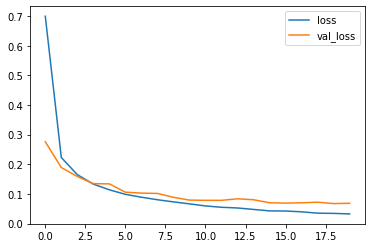

In [16]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### Training and Validation Accuracies

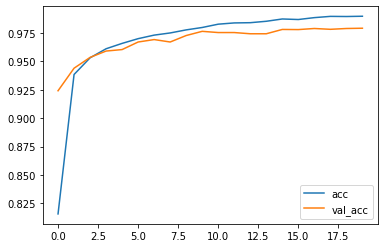

In [17]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()